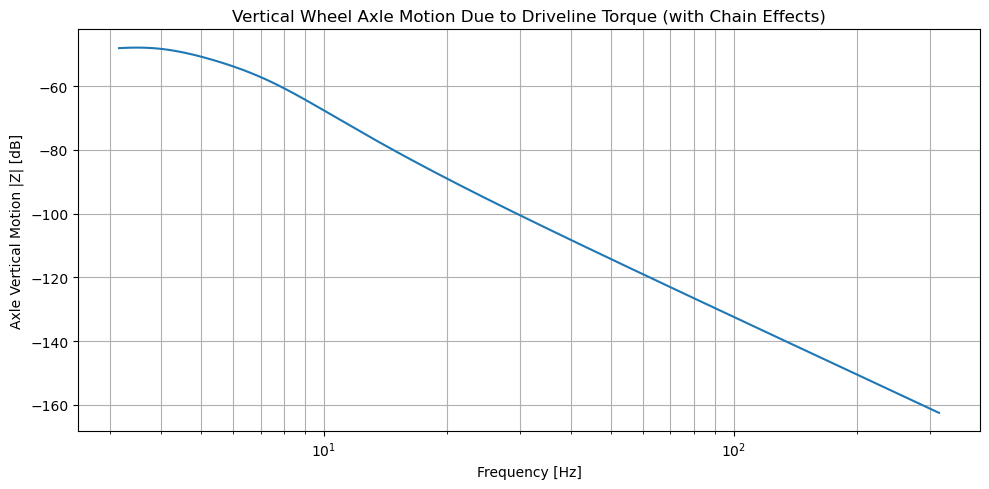

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Frequency sweep setup
frequencies = np.logspace(0.5, 2.5, 1000)  # ~3 Hz to ~316 Hz
omega = 2 * np.pi * frequencies

# --- Driveline (2-inertia) parameters ---
I_drive = 0.1        # kg·m²
I_wheel = 0.1        # kg·m²
kt = 100.0           # Nm/rad
ct = 2.0             # Nms/rad

R_wheel = 0.3        # m (wheel radius)
r_sprocket = 0.1     # m (effective sprocket radius)

# --- Swingarm parameters (rotational) ---
I_swingarm = 0.5     # kg·m² (inertia about pivot)
k_sa = 300.0         # Nm/rad (rotational stiffness)
c_sa = 10.0          # Nms/rad (rotational damping)

# Lever arms (all in meters)
L_ground = 0.35      # ground force arm from pivot
L_chain = 0.25       # chain force arm from pivot
L_axle = 0.4         # vertical position of axle from pivot

# Initialize output array for vertical axle motion
Z_axle_mag = np.zeros_like(omega)

# Frequency loop
for i, w in enumerate(omega):
    # Input: unit sinusoidal torque at driveline input
    T_drive = 1.0

    # Solve 2-inertia torsional system
    H_torsion = np.array([
        [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
        [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
    ])
    B_torsion = np.array([T_drive, 0.0])
    theta = np.linalg.solve(H_torsion, B_torsion)

    # Torque transmitted to wheel
    T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])

    # Forces generating torques on swingarm
    F_drive = T_wheel / R_wheel
    F_chain = T_wheel / r_sprocket

    tau_drive = F_drive * L_ground
    tau_chain = F_chain * L_chain

    # Total excitation torque on swingarm
    tau_exc = tau_drive + tau_chain

    # Swingarm rotational response
    theta_s = tau_exc / (-I_swingarm * w**2 + k_sa + 1j * w * c_sa)

    # Vertical axle motion = L_axle * theta_s
    Z_axle_mag[i] = np.abs(L_axle * theta_s)

# Plot vertical axle motion FRF
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, 20 * np.log10(Z_axle_mag))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Axle Vertical Motion |Z| [dB]')
plt.title('Vertical Wheel Axle Motion Due to Driveline Torque (with Chain Effects)')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [3]:
# Define a subset of representative frequencies for detailed energy analysis
freqs_to_analyze = [5, 10, 15, 20, 30, 50, 80, 120]  # Hz

# Storage for results
energy_data = []

for freq in freqs_to_analyze:
    w = 2 * np.pi * freq
    T_drive = 1.0

    # Solve 2-inertia torsional system
    H_torsion = np.array([
        [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
        [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
    ])
    B_torsion = np.array([T_drive, 0.0])
    theta = np.linalg.solve(H_torsion, B_torsion)

    # Torque at wheel and corresponding forces
    T_wheel = kt * (theta[0] - theta[1]) + 1j * w * ct * (theta[0] - theta[1])
    F_drive = T_wheel / R_wheel
    F_chain = T_wheel / r_sprocket

    # Torques around swingarm pivot
    tau_drive = F_drive * L_ground
    tau_chain = F_chain * L_chain
    tau_total = tau_drive + tau_chain

    # Swingarm response
    theta_s = tau_total / (-I_swingarm * w**2 + k_sa + 1j * w * c_sa)

    # Axle vertical motion
    z_axle = L_axle * theta_s
    z_axle_dot = 1j * w * z_axle

    # Energies
    E_drive = 0.5 * I_drive * (w * np.abs(theta[0]))**2
    E_wheel = 0.5 * I_wheel * (w * np.abs(theta[1]))**2
    E_swingarm = 0.5 * I_swingarm * (w * np.abs(theta_s))**2
    E_spring = 0.5 * k_sa * (np.abs(theta_s))**2
    P_damping = 0.5 * c_sa * (w * np.abs(theta_s))**2

    energy_data.append({
        'Frequency [Hz]': freq,
        '|T_wheel| [Nm]': np.abs(T_wheel),
        '|z_axle| [m]': np.abs(z_axle),
        'E_drive [J]': E_drive,
        'E_wheel [J]': E_wheel,
        'E_swingarm [J]': E_swingarm,
        'E_spring [J]': E_spring,
        'P_damping [W]': P_damping
    })

# Display the results in a table
import pandas as pd


df_energy = pd.DataFrame(energy_data)



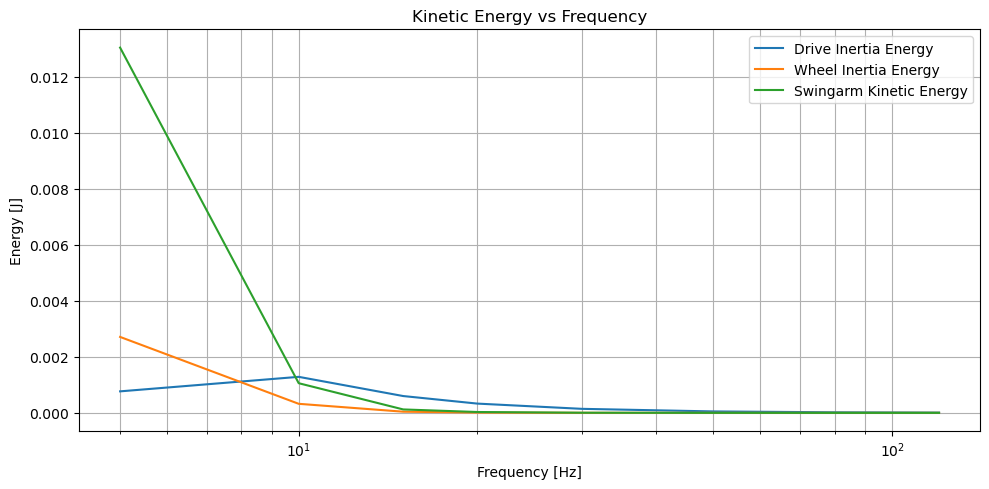

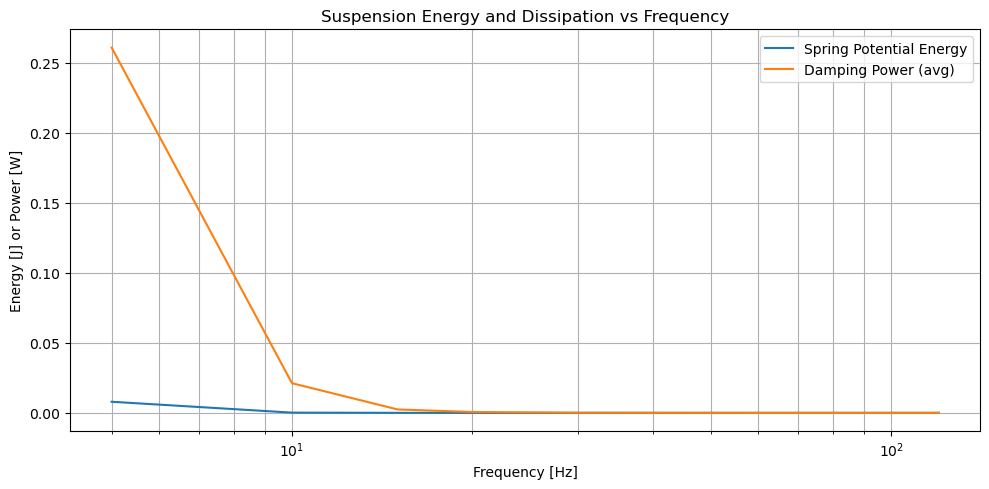

In [4]:
# Extract data for plotting
frequencies = df_energy["Frequency [Hz]"]
E_drive = df_energy["E_drive [J]"]
E_wheel = df_energy["E_wheel [J]"]
E_swingarm = df_energy["E_swingarm [J]"]
E_spring = df_energy["E_spring [J]"]
P_damping = df_energy["P_damping [W]"]

# Plot kinetic energies
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, E_drive, label="Drive Inertia Energy")
plt.semilogx(frequencies, E_wheel, label="Wheel Inertia Energy")
plt.semilogx(frequencies, E_swingarm, label="Swingarm Kinetic Energy")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Energy [J]")
plt.title("Kinetic Energy vs Frequency")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# Plot suspension energy and damping
plt.figure(figsize=(10, 5))
plt.semilogx(frequencies, E_spring, label="Spring Potential Energy")
plt.semilogx(frequencies, P_damping, label="Damping Power (avg)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Energy [J] or Power [W]")
plt.title("Suspension Energy and Dissipation vs Frequency")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


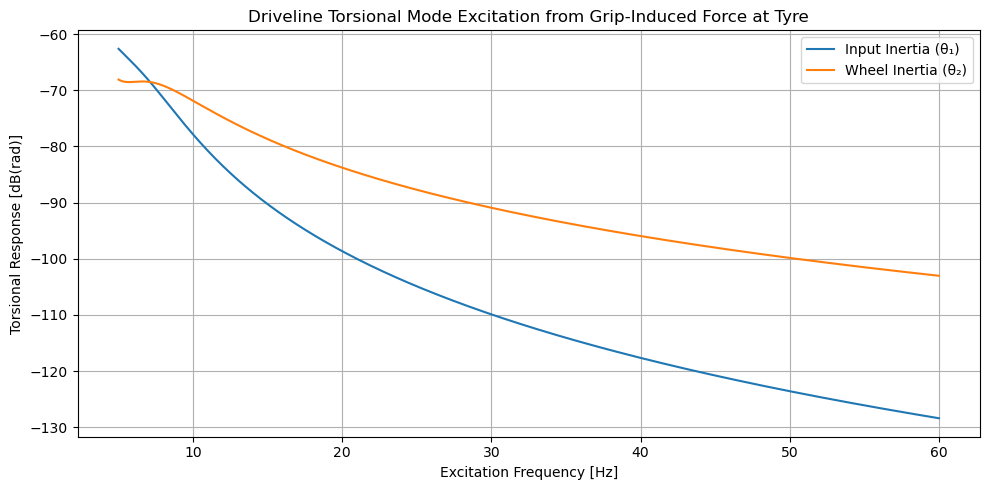

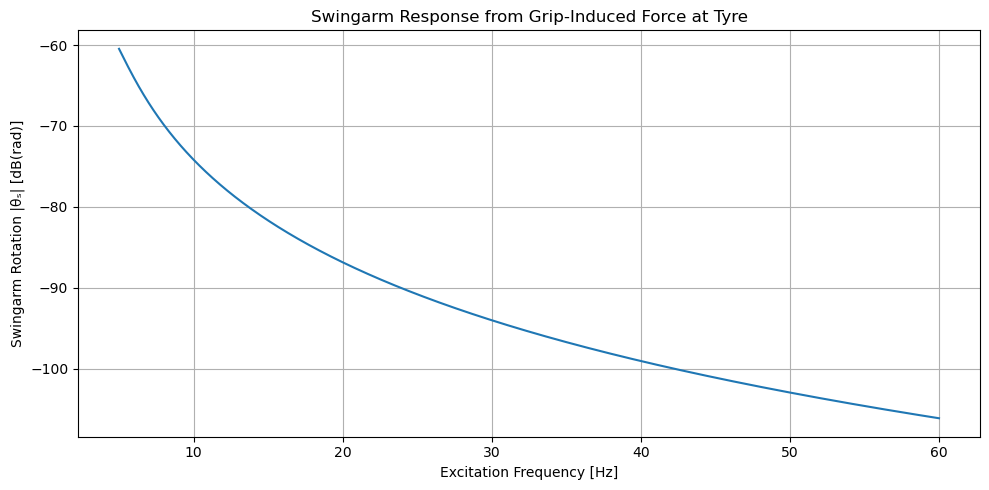

In [5]:
# Frequency sweep setup to target 25 Hz resonance
frequencies = np.linspace(5, 60, 1000)  # Hz (focused around 25 Hz)
omega = 2 * np.pi * frequencies

# System parameters
I_drive = 0.1        # kg·m²
I_wheel = 0.1        # kg·m²
kt = 100.0           # Nm/rad
ct = 2.0             # Nms/rad

R_wheel = 0.3        # m
r_sprocket = 0.1     # m

I_swingarm = 0.5     # kg·m²
k_sa = 300.0         # Nm/rad
c_sa = 10.0          # Nms/rad

# Lever arms
L_ground = 0.35      # m
L_axle = 0.4         # m
L_chain = 0.25       # m

# Output: torsional response of driveline from grip force excitation
theta_drive_mag = np.zeros_like(omega)
theta_wheel_mag = np.zeros_like(omega)
theta_swingarm_mag = np.zeros_like(omega)

# Apply sinusoidal force at ground: F_grip
F_grip_amp = 1.0  # N (unit force fluctuation)

for i, w in enumerate(omega):
    # External torques from grip force
    tau_grip = F_grip_amp * L_ground
    tau_chain = -F_grip_amp * r_sprocket

    # Swingarm equation
    Z_swingarm = -I_swingarm * w**2 + k_sa + 1j * w * c_sa
    theta_s = (tau_grip) / Z_swingarm  # rotational motion of swingarm

    # Angular velocity of swingarm -> chain force -> back torque on wheel
    F_chain = tau_chain / r_sprocket  # force due to sprocket moment arm
    T_wheel_input = F_chain * r_sprocket  # torque acting on wheel (equal and opposite)

    # Driveline 2-DOF torsional response to wheel torque
    H_torsion = np.array([
        [-I_drive * w**2 + kt + 1j * w * ct, -kt - 1j * w * ct],
        [-kt - 1j * w * ct, -I_wheel * w**2 + kt + 1j * w * ct]
    ])
    B_torsion = np.array([0.0, T_wheel_input])  # torque input from wheel side
    theta = np.linalg.solve(H_torsion, B_torsion)

    # Store responses
    theta_drive_mag[i] = np.abs(theta[0])
    theta_wheel_mag[i] = np.abs(theta[1])
    theta_swingarm_mag[i] = np.abs(theta_s)

# Plot: Torsional mode excitation from grip disturbance
plt.figure(figsize=(10, 5))
plt.plot(frequencies, 20 * np.log10(theta_drive_mag), label='Input Inertia (θ₁)')
plt.plot(frequencies, 20 * np.log10(theta_wheel_mag), label='Wheel Inertia (θ₂)')
plt.xlabel('Excitation Frequency [Hz]')
plt.ylabel('Torsional Response [dB(rad)]')
plt.title('Driveline Torsional Mode Excitation from Grip-Induced Force at Tyre')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Swingarm rotation magnitude
plt.figure(figsize=(10, 5))
plt.plot(frequencies, 20 * np.log10(theta_swingarm_mag))
plt.xlabel('Excitation Frequency [Hz]')
plt.ylabel('Swingarm Rotation |θₛ| [dB(rad)]')
plt.title('Swingarm Response from Grip-Induced Force at Tyre')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()
